In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [2]:
class GridWorld(object):

    def __init__(self):
        
        ### Attributes defining the Gridworld #######

        # Shape of the gridworld
        self.shape = (6,6)
        
        # Locations of the obstacles
        self.obstacle_locs = [(1,1),(3,1),(4,1),(4,2),(2,3),(2,5),(4,4)]
        
        # Locations for the absorbing states
        self.absorbing_locs = [(1,0),(4,3)]
        
        # Rewards for each of the absorbing states 
        self.special_rewards = [10,-100] # Corresponds to each of the absorbing_locs
        
        # Reward for all the other states
        self.default_reward = -1
        
        # Starting location
        self.starting_loc = (3,0)
        
        # Action names
        self.action_names = ['N','E','S','W'] # Action 0 is 'N', 1 is 'E' and so on
        
        # Number of actions
        self.action_size = len(self.action_names)
        
        # Randomizing action results: [1 0 0 0] to no Noise in the action results.
        self.action_randomizing_array = [0.8, 0.1, 0.0 , 0.1]
        
        ############################################
    

        #### Internal State  ####
        
        # Get attributes defining the world
        state_size, T, R, absorbing, locs = self.build_grid_world()
        
        # Number of valid states in the gridworld (there are 27 of them - 6x6 grid minus obstacles)
        self.state_size = state_size
        
        # Transition operator (3D tensor)
        self.T = T # T[st+1, st, a] gives the probability that action a will 
                   # transition state st to state st+1
        
        # Reward function (3D tensor)
        self.R = R # R[st+1, st, a ] gives the reward for transitioning to state
                   # st+1 from state st with action a
        
        # Absorbing states
        self.absorbing = absorbing
        
        # The locations of the valid states 
        self.locs = locs # State 0 is at the location self.locs[0] and so on
        
        # Number of the starting state
        self.starting_state = self.loc_to_state(self.starting_loc, locs);
        
        # Locating the initial state
        self.initial = np.zeros((1,len(locs)));
        self.initial[0,self.starting_state] = 1
        
        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape);
        for ob in self.obstacle_locs:
            self.walls[ob]=1
            
        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1
        
        # Placing the rewarders on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for i, rew in enumerate(self.absorbing_locs):
            self.rewarders[rew] = self.special_rewards[i]
        
        #Illustrating the grid world
        self.paint_maps()

        ################################
    
    

    ####### Getters ###########
    
    def get_transition_matrix(self):
        return self.T
    
    def get_reward_matrix(self):
        return self.R
    
    ########################


    
    ####### Methods #########
    
    def value_iteration(self, discount = 0.6, threshold = 0.0001):
        ## Slide 144 of the lecture notes for the algorithm ##
        
        # Transition and reward matrices, both are 3d tensors, c.f. internal state
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        # Initialisation
        epochs = 0
        delta = threshold # Setting value of delta to go through the first breaking condition
        V = np.zeros(self.state_size) # Initialise values at 0 for each state

        while delta >= threshold:
            epochs += 1 # Increment the epoch
            delta = 0 # Reinitialise delta value

            # For each state
            for state_idx in range(self.state_size):

                # If not an absorbing state
                if not(self.absorbing[0, state_idx]):
                  
                    # Store the previous value for that state
                    v = V[state_idx] 

                    # Compute Q value
                    Q = np.zeros(4) # Initialise with value 0
                    for state_idx_prime in range(self.state_size):
                        Q += T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                
                    # Set the new value to the maximum of Q
                    V[state_idx]= np.max(Q) 

                    # Compute the new delta
                    delta = max(delta, np.abs(v - V[state_idx]))
            

        # When the loop is finished, fill in the optimal policy
        optimal_policy = np.zeros((self.state_size, self.action_size)) # Initialisation

        # For each state
        for state_idx in range(self.state_size):
             
            # Compute Q value
            Q = np.zeros(4)
            for state_idx_prime in range(self.state_size):
                Q += T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
            
            # The action that maximises the Q value gets probability 1
            optimal_policy[state_idx, np.argmax(Q)] = 0.6 

        return optimal_policy, epochs


    
    def policy_iteration(self, discount=0.6, threshold = 0.0001):
        ## Slide 139 of the lecture notes for pseudocode ##
        
        # Transition and reward matrices, both are 3d tensors, c.f. internal state
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        # Initialisation
        policy = np.zeros((self.state_size, self.action_size)) # Vector of 0
        policy[:,0] = 1 # Initialise policy to choose action 1 systematically
        epochs = 0
        policy_stable = False # Condition to stop the main loop

        while not(policy_stable): 

            # Policy evaluation
            V, epochs_eval = self.policy_evaluation(policy, threshold, discount)
            epochs += epochs_eval # Increment epoch

            # Set the boolean to True, it will be set to False later if the policy prove unstable
            policy_stable = True

            # Policy iteration
            for state_idx in range(policy.shape[0]):
                
                # If not an absorbing state
                if not(self.absorbing[0,state_idx]):
                    
                    # Store the old action
                    old_action = np.argmax(policy[state_idx,:])
                
                    # Compute Q value
                    Q = np.zeros(4) # Initialise with value 0
                    for state_idx_prime in range(policy.shape[0]):
                        Q += T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])

                    # Compute corresponding policy
                    p = 0.6
                    xp = (1-p)/3
                    new_policy = np.zeros(4) + xp
                    new_policy[np.argmax(Q)] = p  # The action that maximises the Q value gets probability 1
                    policy[state_idx] = new_policy
                
                    # Check if the policy has converged
                    if old_action != np.argmax(policy[state_idx]):
                        policy_stable = False
            
        return V, policy, epochs
                
        
    
    def policy_evaluation(self, policy, threshold, discount):
        
        # Make sure delta is bigger than the threshold to start with
        delta= 2*threshold
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()
        
        # The value is initialised at 0
        V = np.zeros(policy.shape[0])
        # Make a deep copy of the value array to hold the update during the evaluation
        Vnew = np.copy(V)
        
        epoch = 0
        # While the Value has not yet converged do:
        while delta>threshold:
            epoch += 1
            for state_idx in range(policy.shape[0]):
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):
                    continue   
                
                # Accumulator variable for the Value of a state
                tmpV = 0
                for action_idx in range(policy.shape[1]):
                    # Accumulator variable for the State-Action Value
                    tmpQ = 0
                    for state_idx_prime in range(policy.shape[0]):
                        tmpQ = tmpQ + T[state_idx_prime,state_idx,action_idx] * (R[state_idx_prime,state_idx, action_idx] + discount * V[state_idx_prime])
                    
                    tmpV += policy[state_idx,action_idx] * tmpQ
                    
                # Update the value of the state
                Vnew[state_idx] = tmpV
            
            # After updating the values of all states, update the delta
            # Note: The below is our example way of computing delta.
            #       Other stopping criteria may be used (for instance mean squared error).
            #       We encourage you to explore different ways of computing delta to see 
            #       how it can influence outcomes.
            delta =  max(abs(Vnew-V))
            # and save the new value into the old
            V=np.copy(Vnew)
            
        return V, epoch
    
    ##############################################################################
    ####   The Following definitions were adapted from the following github   ####
    #### Reference: https://github.com/buomsoo-kim/Tabular-RL-with-Python.git ####
    ##############################################################################
    
    def generate_episodeFV(self, policy):
        episode = []
        done = False
                
        while not done:
            for state_idx in range(policy.shape[0]):
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):
                    continue   
                
                next_state = state_idx
                reward = -1
                
                episode.append((next_state, reward))
            
                if next_state == 0:
                    done = True
                current_state = next_state                    
        
        return episode

    def generate_episode(self, policy):
        episode = []
        done = False
                
        while not done:
            for state_idx in range(policy.shape[0]):
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):
                    continue   
                
                next_state = state_idx
                reward = -1
                
                action = np.argmax(policy[state_idx,:])
                
                episode.append((next_state, action, reward))
            
                if next_state == 0:
                    done = True
                current_state = next_state                    
        
        return episode
    
    def monte_carlo_FV(self, iterations):
        # The value is initialised at 0
        V, policy, epochs = self.policy_iteration()
        values = np.zeros(policy.shape[0])
        returns = dict()
        
        epochs = 0
        
        already_visited = []

        # For each state
        for state_idx in range(policy.shape[0]):
            returns[state_idx] = list()
            
            if(self.absorbing[0,state_idx]):
                already_visited.append(state_idx)
                
        
        for i in range(iterations):
            epochs += 1 # Increment the epoch
            episode = self.generate_episodeFV(policy)
            
            for s, r in episode:
                if s not in already_visited:
                    already_visited.append(s)
                    idx = episode.index((s, r))
                    G = 0
                    j = 1
                    while j + idx < len(episode):
                        G = 0.6 * (G + episode[j + idx][1])
                        j += 1
                    returns[s].append(G)
                    values[s] = np.mean(returns[s])
    
        return values, returns, epochs
    
    def monte_carlo_EV(self, iterations):
        # The value is initialised at 0
        V, policy, epochs = self.policy_iteration()
        values = np.zeros(policy.shape[0])
        returns = dict()
        absorbing = []
           
        # For each state
        for state_idx in range(policy.shape[0]):
            returns[state_idx] = list()
            
            if(self.absorbing[0,state_idx]):
                absorbing.append(state_idx)
    
        for i in range(iterations):
            episode = self.generate_episode(policy)
            for s, r in episode:
                if s not in absorbing:    # exclude terminal state (0)
                    idx = episode.index((s, r))
                    G = 0
                    j = 1
                    while j + idx < len(episode):
                        G = 0.6 * (G + episode[j + idx][1])
                        j += 1
                    returns[s].append(G)
                    values[s] = np.mean(returns[s])
        return values, returns
    
    
    def generate_random_policy(self):
        pi = dict()
        
        # Initialisation
        policy = np.zeros((self.state_size, self.action_size)) # Vector of 0
        policy[:,0] = 1 # Initialise policy to choose action 1 systematically
        epochs = 0
        policy_stable = False # Condition to stop the main loop
        
        while not(policy_stable): 
            # Set the boolean to True, it will be set to False later if the policy prove unstable
            policy_stable = True

            # Policy iteration
            for state in range(policy.shape[0]):
                actions = []
                prob = []
                
                for action in self.action_names:
                    actions.append(action)
                    prob.append(0.25)
                pi[state] = (actions, prob)
        return pi
    
    
    def generate_any_policy(self):
        pi = dict()
        
        # Initialisation
        policy = np.zeros((self.state_size, self.action_size)) # Vector of 0
        policy[:,0] = 1 # Initialise policy to choose action 1 systematically
        epochs = 0
        policy_stable = False # Condition to stop the main loop
        
        while not(policy_stable): 
            # Set the boolean to True, it will be set to False later if the policy prove unstable
            policy_stable = True

            # Policy iteration
            for state in range(policy.shape[0]):
                r = sorted(np.random.sample(3))
                actions = self.action_names
                prob = [r[0], r[1] - r[0], r[2] - r[1], 1-r[2]]
                pi[state] = (actions, prob)
        
        return pi
    
    def generate_greedy_policy(self, episode):
        # Initialisation
        pi = np.zeros((self.state_size, self.action_size)) # Vector of 0
        pi[:,0] = 1 # Initialise policy to choose action 1 systematically
        
        for state in range(pi.shape[0]):
            # If not an absorbing state
            if not(self.absorbing[0,state]):
                actions = []                
                prob = []
                    
                action = self.action_names
                actions.append(action)
                
                for s, a, r in episode:
                    if s == state:
                        for i in range(self.action_size):
                            if i == a:
                                prob.append(0.6)
                            else:
                                prob.append(0.13)       
                
            pi[state] = prob
        
        return pi
        
    
    def monte_carlo_es(self, iterations):
        pi = self.generate_any_policy()
        Q = dict()
        returns = dict()
        
        for state_idx in range(self.state_size):
            for action_idx in range(self.action_size):
                Q[(state_idx,action_idx)] = []
                returns[(state_idx,action_idx)] = []
    
        for _ in range(iterations):
            s0, a0 = np.random.choice(self.state_size), np.random.choice(self.action_names)
            episode = self.generate_episode(pi)
            
            already_visited = []

            # For each state
            for state_idx in range(self.state_size):
                for action_idx in self.action_names:
                    if(self.absorbing[0,state_idx]):
                        visited = [state_idx, action_idx]
                        already_visited.append(visited)
            
            for s, a, r in episode:
                if (s, a) not in already_visited:
                    already_visited.append((s, a))
                    idx = episode.index((s, a, r))
                    G = 0
                    
                    for j in range(idx, len(episode)):
                        G = 0.6 * (G + episode[j][-1])
                    returns[(s,a)] = G
                Q[(s,a)] = np.mean(returns[(s,a)])
                    
            pi = self.generate_greedy_policy(Q)
        
        return Q
    
    def generate_episode2(self, s0, a0, policy):
        episode = []
        done = False
        current_state, action = s0, a0
        episode.append((current_state, action, -1))
    
        while not done:
            for state in range(self.state_size):
                
                next_state = state
                reward = -1
                
                pr = policy[current_state][1]
                ## to make non-deterministic episode (mostly to avoid infinite episode due to greediness)
                pr[np.argmax(pr)] -= .2
                pr[np.random.choice(np.delete(np.arange(4), np.argmax(pr)))] += .1
                pr[np.random.choice(np.delete(np.arange(4), np.argmax(pr)))] += .05
                pr[np.random.choice(np.delete(np.arange(4), np.argmax(pr)))] += .05
                ##
                action = np.random.choice(policy[current_state][0], p = pr)                
                episode.append((next_state, action, reward))
        
                if next_state == 0:   
                    done = True
                current_state = next_state
        return episode[:-1]
    
    # alpha corresponds to learning rate (i.e., step size)
    def tabular_td(self, alpha, num_iter):
        V = np.zeros(self.state_size) # Initialise values at 0 for each state
        pi = self.generate_any_policy()
        
        epochs = 0
    
        for _ in range(num_iter):
            epochs += 1 # Increment each episode
            s0, a0 = np.random.choice(self.state_size), np.random.choice(self.action_size)
            episode = self.generate_episode2(s0, a0, pi)
            already_visited = set()
        
            for step in range(len(episode)):
                current_state, action = episode[step][0], episode[step][1]
                
                for state in range(self.state_size):
                    next_state = state
                    reward = -1
                    
                    V[current_state] += alpha * (reward + 0.6 * V[next_state] - V[current_state])            
        return V, epochs
    
    # selects action epsilon-greedily, given current state
    def e_greedy(self, e, q, state):
        action_values = []
        prob = []
        for action in range(self.action_size):
            action_values.append(action)
        for i in range(len(action_values)):
            if i == np.argmax(action_values):
                prob.append(1 - e + e/len(action_values))
            else:
                prob.append(e/len(action_values))
        
        return np.random.choice(self.action_size, p = prob)
    
    def state_transition(self, state, action):
        next_state, reward = None, None
        for state_idx in range(self.state_size):
            for action_idx in range(self.action_size):
                if state_idx == state and action_idx == action:
                    next_state = state_idx +1
                    reward = -1
        return next_state, reward
    
    
    def state_action_value(self):
        q = dict()
        
        for state in range(self.state_size):
            for action in range(self.action_size):
                q[(state, action)] = np.random.normal()
        
        return q

    def greedy_policy(self, Q):
        pi = np.zeros((self.state_size, self.action_size)) # Vector of 0
        pi[:,0] = 1 # Initialise policy to choose action 1 systematically
        
        for state in range(self.state_size):
            actions = []
            q_values = []
            prob = []
        
            for a in range(self.action_size):
                actions.append(a)
                q_values.append(Q[state,a])   
            
            for i in range(len(q_values)):
                if i == np.argmax(q_values):
                    prob.append(0.6)
                else:
                    prob.append(0.13)       
                
            pi[state] = prob
        
        return pi
    
    def sarsa(self, epsilon, alpha, num_iter):
        Q = self.state_action_value()
        
        epochs = 0
        
        for _ in range(num_iter):
            epochs += 1 # Increment each episode
            current_state = np.random.choice(self.state_size)
            current_action = self.e_greedy(epsilon, Q, current_state)
            
            while current_state < 28:
                next_state, reward = self.state_transition(current_state, current_action)
                next_action = self.e_greedy(epsilon, Q, next_state)

                Q_diff = Q[next_state, next_action] - Q[current_state, current_action]
                Q[current_state, current_action] += alpha * (reward + (0.6 * Q_diff))
                current_state, current_action = next_state, next_action
        
        pi_hat = self.greedy_policy(Q)
        #print(pi_hat[0])

        values =  np.zeros(self.state_size) # Initialise values at 0 for each state
        for i in range(len(pi_hat)):
            d = np.where(pi_hat[i] == 0.6)
            idx = int(d[0])
            values[i] = Q[i,idx]
        
        return values, pi_hat, epochs
    
    ##############################################################################
    ####        Here the adapted definition from the reference end            ####
    #### Reference: https://github.com/buomsoo-kim/Tabular-RL-with-Python.git ####
    ##############################################################################
    
    ##########################
    
    ########### Internal Drawing Functions #####################

    ## You do not need to understand these functions in detail in order to complete the lab ##
    
    def parameter_change_SARSA(self, alpha, epsilon, runs):
        run = runs
        epi = 1000
        x = []
        a = alpha
        e = epsilon
        y = []
        for i in range(run):
            x.append(i)
            values, policy, epochs = self.sarsa(epsilon=e, alpha=a, num_iter=epi)
            summ_r = 0
            for xr in values:
                summ_r += xr
            r = summ_r/len(values)
            y.append(r)
    
        return x, y
    
    

    def draw_deterministic_policy(self, Policy):
        # Draw a deterministic policy
        # The policy needs to be a np array of 29 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
        #plt.hold('on')
        for state, action in enumerate(Policy):
            if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
                continue
            arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
            action_arrow = arrows[action] # Take the corresponding action
            location = self.locs[state] # Compute its location on graph
            plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    
        plt.show()

    
    def draw_value(self, Value):
        # Draw a policy value function
        # The value need to be a np array of 22 values 
        plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
        for state, value in enumerate(Value):
            if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
                continue
            location = self.locs[state] # Compute the value location on graph
            plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    
        plt.show()


    def draw_deterministic_policy_grid(self, Policy, title, n_columns, n_lines):
        # Draw a grid of deterministic policy
        # The policy needs to be an arrya of np array of 29 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure(figsize=(20,8))
        for subplot in range (len(Policy)): # Go through all policies
          ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
          ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
          for state, action in enumerate(Policy[subplot]):
              if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
                  continue
              arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
              action_arrow = arrows[action] # Take the corresponding action
              location = self.locs[state] # Compute its location on graph
              plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
          ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
        plt.show()

    def draw_value_grid(self, Value, title, n_columns, n_lines):
        # Draw a grid of value function
        # The value need to be an array of np array of 22 values 
        plt.figure(figsize=(20,8))
        for subplot in range (len(Value)): # Go through all values
          ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
          ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
          for state, value in enumerate(Value[subplot]):
              if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
                  continue
              location = self.locs[state] # Compute the value location on graph
              plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
          ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
        plt.show()

    ##########################
    
    
    ########### Internal Helper Functions #####################

    ## You do not need to understand these functions in detail in order to complete the lab ##

    def paint_maps(self):
        # Helper function to print the grid word used in __init__
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(self.walls)
        plt.title('Obstacles')
        plt.subplot(1,3,2)
        plt.imshow(self.absorbers)
        plt.title('Absorbing states')
        plt.subplot(1,3,3)
        plt.imshow(self.rewarders)
        plt.title('Reward states')
        plt.show()
        

    def build_grid_world(self):
        # Get the locations of all the valid states, the neighbours of each state (by state number),
        # and the absorbing states (array of 0's with ones in the absorbing states)
        locations, neighbours, absorbing = self.get_topology()
        
        # Get the number of states
        S = len(locations)
        
        # Initialise the transition matrix
        T = np.zeros((S,S,4))
        
        for action in range(4):
            for effect in range(4):
                # Randomize the outcome of taking an action
                outcome = (action+effect+1) % 4
                if outcome == 0:
                    outcome = 3
                else:
                    outcome -= 1

                # Fill the transition matrix:
                # A good way to understand the code, is to first ask ourselves what the structure 
                # of the transition probability ‘matrix’ should be, given that we have state, successor state and action. 
                # Thus, a simple row x column matrix of successor state and will not suffice, as we also have to condition 
                #  on the action. So we can therefore choose to implement this to  have a structure that is 3 dimensional
                # (technically a tensor, hence the variable name T). I would not worry too much about what a tensor is, 
                # it is simply an array that takes 3 arguments to get a value, just like conventional matrix is an array that
                # takes 2 arguments (row and column), to get a value. To touch all the elements in this structure we
                # need therefore to loop over states and actions.

                prob = self.action_randomizing_array[effect]
                for prior_state in range(S):
                    post_state = neighbours[prior_state, outcome]
                    post_state = int(post_state)
                    T[post_state,prior_state,action] = T[post_state,prior_state,action]+prob
                    
    
        # Build the reward matrix
        R = self.default_reward*np.ones((S,S,4))
        for i, sr in enumerate(self.special_rewards):
            post_state = self.loc_to_state(self.absorbing_locs[i],locations)
            R[post_state,:,:]= sr
        
        return S, T,R,absorbing,locations
    

    def get_topology(self):
        height = self.shape[0]
        width = self.shape[1]
        
        index = 1 
        locs = []
        neighbour_locs = []
        
        for i in range(height):
            for j in range(width):
                # Get the locaiton of each state
                loc = (i,j)
                
                #And append it to the valid state locations if it is a valid state (ie not absorbing)
                if(self.is_location(loc)):
                    locs.append(loc)
                    
                    # Get an array with the neighbours of each state, in terms of locations
                    local_neighbours = [self.get_neighbour(loc,direction) for direction in ['nr','ea','so', 'we']]
                    neighbour_locs.append(local_neighbours)
                
        # translate neighbour lists from locations to states
        num_states = len(locs)
        state_neighbours = np.zeros((num_states,4))
        
        for state in range(num_states):
            for direction in range(4):
                # Find neighbour location
                nloc = neighbour_locs[state][direction]
                
                # Turn location into a state number
                nstate = self.loc_to_state(nloc,locs)
      
                # Insert into neighbour matrix
                state_neighbours[state,direction] = nstate;
                
    
        # Translate absorbing locations into absorbing state indices
        absorbing = np.zeros((1,num_states))
        for a in self.absorbing_locs:
            absorbing_state = self.loc_to_state(a,locs)
            absorbing[0,absorbing_state] =1
        
        return locs, state_neighbours, absorbing 


    def loc_to_state(self,loc,locs):
        #takes list of locations and gives index corresponding to input loc
        return locs.index(tuple(loc))


    def is_location(self, loc):
        # It is a valid location if it is in grid and not obstacle
        if(loc[0]<0 or loc[1]<0 or loc[0]>self.shape[0]-1 or loc[1]>self.shape[1]-1):
            return False
        elif(loc in self.obstacle_locs):
            return False
        else:
             return True
            
    def get_neighbour(self,loc,direction):
        #Find the valid neighbours (ie that are in the grif and not obstacle)
        i = loc[0]
        j = loc[1]
        
        nr = (i-1,j)
        ea = (i,j+1)
        so = (i+1,j)
        we = (i,j-1)
        
        # If the neighbour is a valid location, accept it, otherwise, stay put
        if(direction == 'nr' and self.is_location(nr)):
            return nr
        elif(direction == 'ea' and self.is_location(ea)):
            return ea
        elif(direction == 'so' and self.is_location(so)):
            return so
        elif(direction == 'we' and self.is_location(we)):
            return we
        else:
            #default is to return to the same location
            return loc
        
###########################################         


Creating the Grid world, represented as:



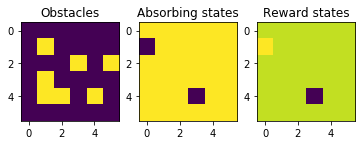

In [3]:
### Define the grid
print("Creating the Grid world, represented as:\n")
grid = GridWorld()

The value of the optimal policy computed using policy iteration is:

 [  5.7415088    0.82196219  -1.2625005   -2.03322888  -2.32506357
  -2.42934129   0.          -1.97563066  -2.25772435  -2.42136445
  -2.46116159   5.25563701   0.59067089  -1.68284565  -2.65756756
   0.63628129  -4.76309649 -21.81530561  -4.34306243  -2.76907552
  -1.23586036   0.          -2.6001076   -2.02929336  -2.51929562
  -4.47777943 -21.80895332  -4.58747709  -2.80232129]


Its graphical representation of value iteration is:



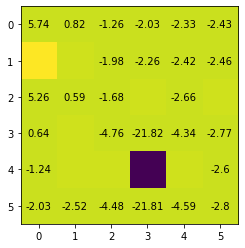


It took 16 epochs



Its graphical representation for policy iteration is:



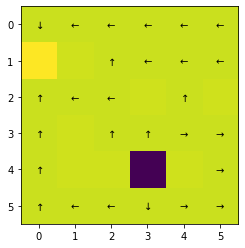


It took 16 epochs



In [7]:
# Policy Iteration algorithm
val, pol_opt, epochs = grid.policy_iteration()

# Value iteration algorithm
pol_opt2, epochs = grid.value_iteration()
#print(pol_opt)

# Plot value function for value iteration
print("The value of the optimal policy computed using policy iteration is:\n\n {}".format(val))
print("\n\nIts graphical representation of value iteration is:\n")
grid.draw_value(val)

# Plot number of epochs
print("\nIt took {} epochs\n".format(epochs))

# Plot policy for policy iteration
print("\n\nIts graphical representation for policy iteration is:\n")
grid.draw_deterministic_policy(np.array([np.argmax(pol_opt[row,:]) for row in range(grid.state_size)]))

# Plot number of epochs
print("\nIt took {} epochs\n".format(epochs))



Impact of gamma value on the number of epochs needed for the value iteration algorithm:



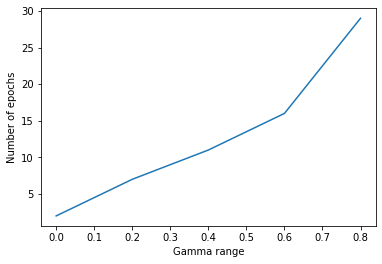


Graphical representation of the policy for each gamma:



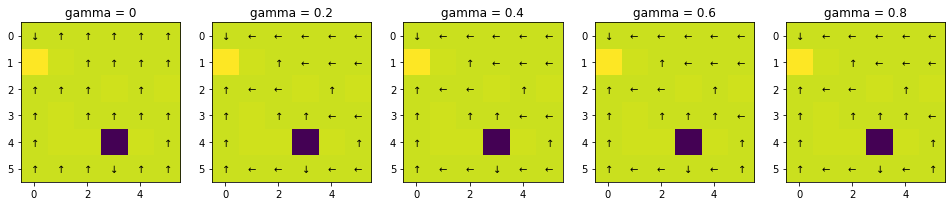

In [5]:
# Impact of gamma on the value iteration algorithm
gamma_range = [0, 0.2, 0.4, 0.6, 0.8]
epochs_needed = []
pols_needed = []
pols_title = []

# Use value iteration for each gamma value
for gamma in gamma_range:
    pol_opt2, epochs = grid.value_iteration(discount = gamma)
    epochs_needed.append(epochs)
    pols_needed.append(np.array([np.argmax(pol_opt2[row,:]) for row in range(grid.state_size)]))
    pols_title.append("gamma = {}".format(gamma))

# Plot the number of epochs vs gamma values
print("\nImpact of gamma value on the number of epochs needed for the value iteration algorithm:\n")
plt.figure()
plt.plot(gamma_range, epochs_needed)
plt.xlabel("Gamma range")
plt.ylabel("Number of epochs")
plt.show()

# Print all policies for different values of gamma
print("\nGraphical representation of the policy for each gamma:\n")
grid.draw_deterministic_policy_grid(pols_needed, pols_title, 1, 6)



Impact of gamma value on the number of epochs needed for the policy iteration algorithm:



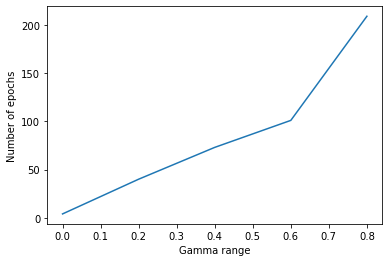


Graphical representation of the value function for each gamma:



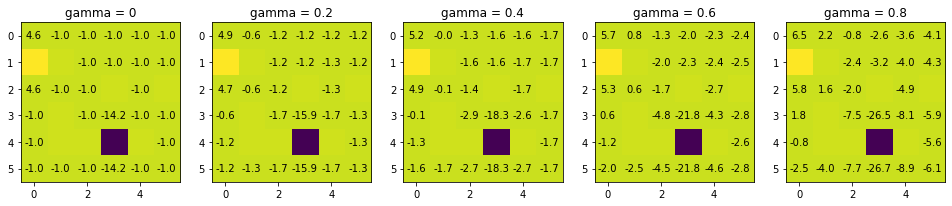


Graphical representation of the policy for each gamma:



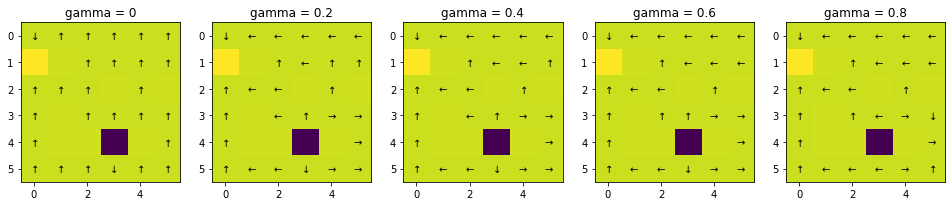

In [6]:
# Impact of gamma on the policy iteration algorithm

gamma_range = [0, 0.2, 0.4, 0.6, 0.8]
epochs_needed = []
pols_needed = []
vals_needed = []
titles = []

# Use policy iteration for each gamma value
for gamma in gamma_range:
    V_opt, pol_opt, epochs = grid.policy_iteration(discount = gamma)
    epochs_needed.append(epochs)
    pols_needed.append(np.array([np.argmax(pol_opt[row,:]) for row in range(grid.state_size)]))
    vals_needed.append(V_opt)
    titles.append("gamma = {}".format(gamma))


# Plot the number of epochs vs gamma values
print("\nImpact of gamma value on the number of epochs needed for the policy iteration algorithm:\n")
plt.figure()
plt.plot(gamma_range, epochs_needed)
plt.xlabel("Gamma range")
plt.ylabel("Number of epochs")
plt.show()

# Print all value functions and policies for different values of gamma
print("\nGraphical representation of the value function for each gamma:\n")
grid.draw_value_grid(vals_needed, titles, 1, 6)

print("\nGraphical representation of the policy for each gamma:\n")
grid.draw_deterministic_policy_grid(pols_needed, titles, 1, 6)




The value of that policy with gamma = 0.6 is:

 [  2.18655806  -1.46310376  -2.34847238  -2.49274369  -2.54113713
  -2.51952616   0.          -2.68665533  -2.57063957  -2.72232738
  -2.55149512   1.43579676  -1.90065203  -3.63992016  -3.82048043
  -1.63060122  -9.37351889 -33.43778449  -8.44167689  -3.91304566
  -2.37978192   0.          -3.1549007   -2.80993875  -4.0684572
  -9.5115139  -33.65378671  -9.52801975  -4.14578992]


Its graphical representation is:



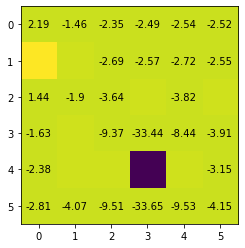


It took 17 epochs



In [7]:
### Study of a uniform policy (p = 0.25)

# Plot policy
Policy = np.zeros((grid.state_size, grid.action_size))
Policy = Policy + 0.25
#print("Considering the uniform (unbiased) policy:\n\n {}".format(Policy))
# Do not plot a graphical representation for this policy as it is fully random

# Policy evaluation for gamma = 0.6
val, epochs = grid.policy_evaluation(Policy, 0.001, 0.6)

# Plot value function
print("\n\nThe value of that policy with gamma = 0.6 is:\n\n {}".format(val))
print("\n\nIts graphical representation is:\n")
grid.draw_value(val)

# Plot number of epochs
print("\nIt took {} epochs\n".format(epochs)) 


The value of the optimal value function computed using First_visit MC Prediction is:

 [-1.49999744 -1.49999574 -1.49999289 -1.49998815 -1.49998026 -1.49996709
  0.         -1.49994516 -1.4999086  -1.49984766 -1.4997461  -1.49957683
 -1.49929472 -1.49882454 -1.4980409  -1.49673483 -1.49455804 -1.49093007
 -1.48488346 -1.47480576 -1.4580096   0.         -1.430016   -1.38336
 -1.3056     -1.176      -0.96       -0.6         0.        ]


Its graphical representation is:



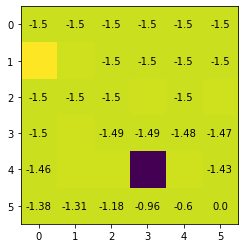


It took 10000 epochs


Impact of number of episodes against reward for the MC First-Visit algorithm:



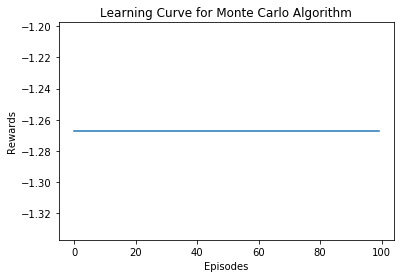

In [17]:
# MONTE CARLO RL
# Estimate the optimal Value Function

values_1, returns_1, epochs_1 = grid.monte_carlo_FV(10000)

# Plot value function for First visit Monte Carlo
print("The value of the optimal value function computed using First_visit MC Prediction is:\n\n {}".format(values_1))
print("\n\nIts graphical representation is:\n")
grid.draw_value(values_1)

# Plot number of epochs
print("\nIt took {} epochs\n".format(epochs_1)) 


run = 100
episodes = 1000
runs = []
a = 0.5
e = 0
rewards_needed = []

# Use policy iteration for each episode
for i in range(run):
    runs.append(i)
    values, returns, epochs = grid.monte_carlo_FV(iterations = episodes)
    summ_r = 0
    for xr in values:
        summ_r += xr
    r = summ_r/len(values)
    rewards_needed.append(r)


# Plot the number of epochs vs gamma values
print("\nImpact of number of episodes against reward for the MC First-Visit algorithm:\n")
plt.figure()
plt.plot(runs, rewards_needed)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("Learning Curve for Monte Carlo Algorithm")
plt.show()



Its graphical representation for policy iteration is:



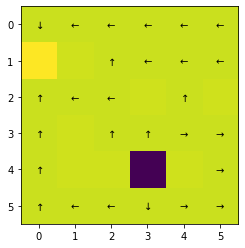

In [19]:
val, Policy, epochs = grid.policy_iteration()

episode = grid.generate_episode(Policy)
#print(episode)
pi = grid.generate_greedy_policy(episode)
#print(pi)

# Plot policy for policy iteration
print("\n\nIts graphical representation for policy iteration is:\n")
grid.draw_deterministic_policy(np.array([np.argmax(pi[row,:]) for row in range(grid.state_size)]))

The value of the optimal value function computed using Temporal Difference Prediction is:

 [-1.44500592 -1.44500592 -1.44500592 -1.44500592 -1.44500593 -1.44500594
 -1.44500595 -1.44500598 -1.44500604 -1.44500616 -1.4450064  -1.44500689
 -1.44500785 -1.44500978 -1.44501365 -1.44502137 -1.44503683 -1.44506773
 -1.44512952 -1.44525307 -1.44549999 -1.44599313 -1.44697665 -1.44893273
 -1.45280169 -1.4603718  -1.47487824 -1.50162054  0.        ]


Its graphical representation is:



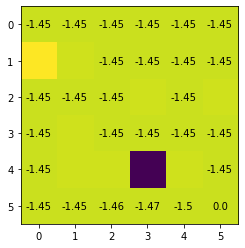


Impact of number of episodes against reward for the TD algorithm:



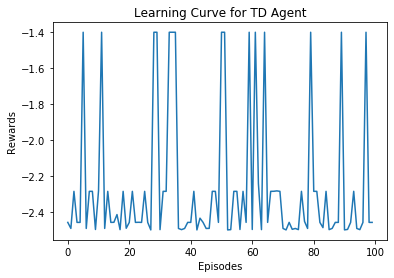

In [16]:
# Temporal Difference RL
# Estimate the optimal Value Function

values_TD, epochs = grid.tabular_td(0.5, 10)

# Plot value function for First visit Monte Carlo
print("The value of the optimal value function computed using Temporal Difference Prediction is:\n\n {}".format(values_TD))
print("\n\nIts graphical representation is:\n")
grid.draw_value(values_TD)


run = 100
episodes = 10
runs = []
a = 0.5
e = 0
rewards_needed = []

# Use policy iteration for each episode
for i in range(run):
    runs.append(i)
    values, epochs = grid.tabular_td(alpha=a, num_iter=episodes)
    summ_r = 0
    for xr in values:
        summ_r += xr
    r = summ_r/len(values)
    rewards_needed.append(r)

# Plot the number of epochs vs gamma values
print("\nImpact of number of episodes against reward for the TD algorithm:\n")
plt.figure()
plt.plot(runs, rewards_needed)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("Learning Curve for TD Agent")
plt.show()

The value of the optimal value function computed using SARSA is:

 [ 1.17635328 -0.09884153  1.69707795  0.52157014  2.01427173  1.87309293
  1.2594352  -0.08470909  1.2008146   0.25253     0.65556509  0.60906012
 -0.05879166  0.34889841  1.87657067  0.80830317 -0.49322674 -0.04248526
 -0.22341461 -0.0931301   1.72127221  0.16419373 -0.20844199  0.1771646
  1.55960067  1.29932383  1.0299741   0.62591069  0.46567475]


Its graphical representation is:



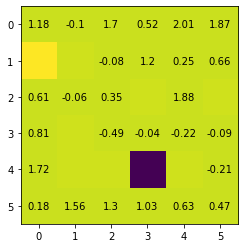



Its graphical representation for SARSA is:



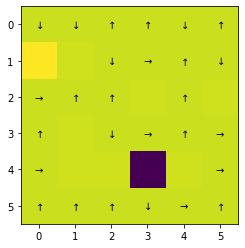


It took 10000 epochs



In [12]:
# SARSA - On-policy TD Control
q = grid.state_action_value()
#print(q)

Q, pi_hat, iterations = grid.sarsa(0, 0.5, 10000)
#print(Q)
#print(pi_hat)

# Plot value function for SARSA
print("The value of the optimal value function computed using SARSA is:\n\n {}".format(Q))
print("\n\nIts graphical representation is:\n")
grid.draw_value(Q)

# Plot policy for SARSA
print("\n\nIts graphical representation for SARSA is:\n")
grid.draw_deterministic_policy(np.array([np.argmax(pi_hat[row,:]) for row in range(grid.state_size)]))

# Plot number of iterations
print("\nIt took {} epochs\n".format(iterations)) 


Impact of number of episodes against reward for the SARSA algorithm:



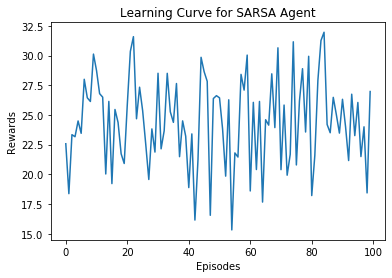

In [31]:
# SARSA Learning Curve
run = 100
episodes = 1000
runs = []
a = 0.5
e = 0
rewards_needed = []

# Use policy iteration for each episode
for i in range(run):
    runs.append(i)
    values, policy, epochs = grid.sarsa(epsilon=e, alpha=a, num_iter=episodes)
    summ_r = 0
    for xr in values:
        summ_r += xr
    r = summ_r/len(values)
    rewards_needed.append(summ_r)

# Plot the number of epochs vs gamma values
print("\nImpact of number of episodes against reward for the SARSA algorithm:\n")
plt.figure()
plt.plot(runs, rewards_needed)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("Learning Curve for SARSA Agent")
plt.show()

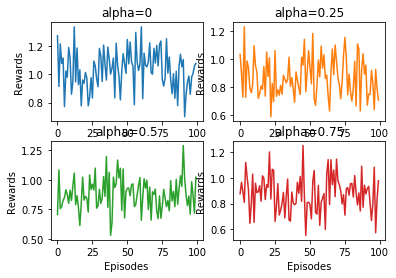

In [26]:
# SARSA Learning Curve - format of method: alpha, epsilon, runs

#changing alpha
x0, y0 = grid.parameter_change_SARSA(0,0,100)
x1, y1 = grid.parameter_change_SARSA(0.25,0,100)
x2, y2 = grid.parameter_change_SARSA(0.5,0,100)
x3, y3 = grid.parameter_change_SARSA(0.75,0,100)

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x0, y0)
axs[0, 0].set_title('alpha=0')
axs[0, 1].plot(x1, y1, 'tab:orange')
axs[0, 1].set_title('alpha=0.25')
axs[1, 0].plot(x2, y2, 'tab:green')
axs[1, 0].set_title('alpha=0.5')
axs[1, 1].plot(x3, y3, 'tab:red')
axs[1, 1].set_title('alpha=0.75')

for ax in axs.flat:
    ax.set(xlabel='Episodes', ylabel='Rewards')

IndexError: too many indices for array

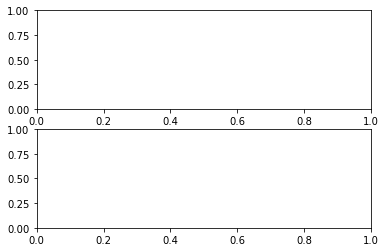

In [4]:
# SARSA Learning Curve - format of method: alpha, epsilon, runs
#changing epsilon

x4, y4 = grid.parameter_change_SARSA(0.5,0,100)
x5, y5 = grid.parameter_change_SARSA(0.5,1,100)

fig2, axs2 = plt.subplots(2, 1)
axs2[0, 0].plot(x4, y4)
axs2[0, 0].set_title('epsilon=0')
axs2[0, 1].plot(x5, y5, 'tab:red')
axs2[0, 1].set_title('epsilon=1')

for ax in axs2.flat:
    ax.set(xlabel='Episodes', ylabel='Rewards')

In [9]:
# Root Mean Square Error

# Dynamic Programming value function:
valDP, polDP, epochsDP = grid.policy_iteration()

# Monte Carlo value function:
valMC, returnsMC, epochsMC = grid.monte_carlo_FV(10000)

# TD SARSA value function:
valTD, polTD, epochsTD = grid.sarsa(0, 0.5, 10000)

# TD vs DP
MSE_TD = np.square(np.subtract(valDP, valTD)).mean()
RMSE_TD = np.sqrt(MSE_TD)

print("\nRoot Mean Square Error DP vs TD:\n")
print(RMSE_TD)

#MC vs DP
MSE_MC = np.square(np.subtract(valDP, valMC)).mean()
RMSE_MC = np.sqrt(MSE_MC)

print("\nRoot Mean Square Error DP vs MC:\n")
print(RMSE_MC)


Root Mean Square Error DP vs TD:

7.160759062383924

Root Mean Square Error DP vs MC:

5.943612782233839



Impact of number of episodes against reward for the SARSA algorithm:



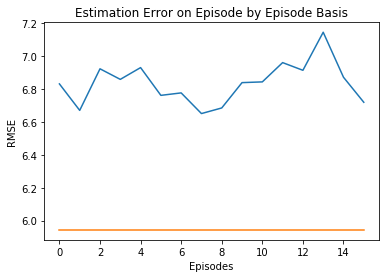

In [11]:
# Plot RMSE vs Episodes for TD SARSA learning
run = 16
runsTD = []
rmseTD = []

# Plot RMSE_TD vs Epsiodes 
for i in range(run):
    runsTD.append(i)
    valTD, polTD, epochsTD = grid.sarsa(0, 0.5, 10000)
    valDP, polDP, epochsDP = grid.policy_iteration()
    MSE_TD = np.square(np.subtract(valDP, valTD)).mean()
    RMSE_TD = np.sqrt(MSE_TD)
    rmseTD.append(RMSE_TD)

# Plot RMSE vs Episodes for MC learning
run = 16
runsMC = []
rmseMC = []

# Plot RMSE_MC vs Epsiodes 
for i in range(run):
    runsMC.append(i)
    valMC, returnsMC, epochsMC = grid.monte_carlo_FV(10000)
    valDP, polDP, epochsDP = grid.policy_iteration()
    MSE_MC = np.square(np.subtract(valDP, valMC)).mean()
    RMSE_MC = np.sqrt(MSE_MC)
    rmseMC.append(RMSE_MC)
    
print("\nImpact of number of episodes against reward for the SARSA algorithm:\n")
plt.figure()
plt.plot(runsTD, rmseTD, label = "TD")
plt.plot(runsMC, rmseMC, label = "MC")
plt.xlabel("Episodes")
plt.ylabel("RMSE")
plt.title("Estimation Error on Episode by Episode Basis")
plt.show()

In [ ]:
# Plot RMSE vs Episodes for TD SARSA learning
run = 50
runsTD = []
rmseTD = []
rewards_needed = []

# Plot RMSE_TD vs Epsiodes 
for i in range(run):
    runsTD.append(i)
    valTD, polTD, epochsTD = grid.sarsa(0, 0.5, 10000)
    valDP, polDP, epochsDP = grid.policy_iteration()
    MSE_TD = np.square(np.subtract(valDP, valTD)).mean()
    RMSE_TD = np.sqrt(MSE_TD)
    rmseTD.append(RMSE_TD)
    summ_r = 0
    for xr in valTD:
        summ_r += xr
    r = summ_r/len(valTD)
    rewards_needed.append(summ_r)

plt.figure()
plt.plot(rmseTD, rewards_needed)
plt.xlabel("RMSE")
plt.ylabel("Rewards")
plt.title("Estimation error vs rewards for each Episode TD")
plt.show()
    